In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
import cv2
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from collections import Counter
from tqdm import tqdm

### The data is stored inside the 'team' directory

In [2]:
path = '../../team/courses/MSiA400/GrandTeton'

In [3]:
path_real = path + '/Photos-20191020T020916Z-001/Photos/'
path_generated_go = path + '/GO_noGO Data Set_Images/TestGo/'
path_generated_nogo = path + '/GO_noGO Data Set_Images/TestNoGo/'

# Set path for training images
filepaths_go = [f for f in listdir(path_generated_go) if f.endswith('.png')]
filepaths_nogo = [f for f in listdir(path_generated_nogo) if f.endswith('.png')]

In [4]:
# Read all GO and NoGO images into a list
list_img = []
for i in tqdm(filepaths_go):
    list_img.append(cv2.imread(path_generated_go + i))

100%|██████████| 3370/3370 [01:03<00:00, 53.07it/s]


In [5]:
for i in tqdm(filepaths_nogo):
    list_img.append(cv2.imread(path_generated_nogo + i))

100%|██████████| 5001/5001 [01:40<00:00, 49.55it/s] 


In [6]:
n = len(list_img)

In [7]:
n

8371

### Feature Extraction class

In [8]:
from Feature_Extractor_generated import Feature_Extractor
## extracts 9 features from input image using opencv and other classical computer vision packages

### Processing feature vectors for all the images

In [9]:
feature_extractor = Feature_Extractor()

In [10]:
# Create a list called 'levels' to store number of floors for each building
levels = []
for i in tqdm(range(n)):
    n_level = feature_extractor.count_level(list_img[i])
    levels.append(n_level)

100%|██████████| 8371/8371 [00:13<00:00, 602.02it/s]


In [11]:
Counter(levels)

Counter({1: 2037, 3: 3763, 2: 2536, 4: 35})

In [12]:
# Create a list called 'openings' to store number of openings
openings = []
for i in tqdm(range(n)):
    openings.append(feature_extractor.count_openings(list_img[i]))

100%|██████████| 8371/8371 [00:06<00:00, 1231.91it/s]


In [13]:
Counter(openings)

Counter({1: 628,
         2: 1475,
         4: 1056,
         6: 1791,
         3: 1654,
         5: 389,
         7: 276,
         9: 881,
         8: 220,
         0.0: 1})

In [14]:
# Create a list called 'fraction_widths' to store proportion of sum of all windows' widths (without overlap), (on all floors) 
# to the overall width of building
fraction_widths = []
for i in tqdm(range(len(list_img))):
    fraction_widths.append(feature_extractor.fraction_width(list_img[i]))

100%|██████████| 8371/8371 [00:08<00:00, 977.61it/s] 


In [15]:
# Create a list called 'avg_fraction_widths' to store proportion of average of all windows' widths (over all floors) 
# to the overall width of building
avg_fraction_widths = []
for i in tqdm(range(len(list_img))):
    avg_fraction_widths.append(feature_extractor.avg_fraction_width(list_img[i]))

100%|██████████| 8371/8371 [00:23<00:00, 359.24it/s]


In [16]:
# Create a list called 'fraction_heights' to store proportion of sum of all windows' heights (without overlap), on all floors 
# to the overall height of building
fraction_heights = []
for i in tqdm(range(len(list_img))):
    fraction_heights.append(feature_extractor.fraction_height(list_img[i]))

100%|██████████| 8371/8371 [00:08<00:00, 1016.27it/s]


In [17]:
# Create a list called 'aggregate_fraction_heights' to store proportion of sum of all windows' heights (on all floors) 
# to the overall height of building
aggregate_fraction_heights = []
for i in tqdm(range(len(list_img))):
    aggregate_fraction_heights.append(feature_extractor.aggregate_fraction_height(list_img[i]))

100%|██████████| 8371/8371 [00:07<00:00, 1179.28it/s]


In [18]:
# Create a list called 'img_widths' to store the pixel widths of all images
img_widths = []
for i in tqdm(range(len(list_img))):
    img_widths.append(feature_extractor.img_width(list_img[i]))

100%|██████████| 8371/8371 [00:00<00:00, 512009.20it/s]


In [19]:
# Create a list called 'img_heights' to store the pixel widths of all images
img_heights = []
for i in tqdm(range(len(list_img))):
    img_heights.append(feature_extractor.img_height(list_img[i]))

100%|██████████| 8371/8371 [00:00<00:00, 516020.03it/s]


In [20]:
# Create a list called 'img_heights' to store the pixel widths of all images
fraction_areas = []
for i in tqdm(range(len(list_img))):
    fraction_areas.append(feature_extractor.fraction_area(list_img[i]))

100%|██████████| 8371/8371 [00:06<00:00, 1387.44it/s]


In [21]:
# Extract image index (four digit number)
files_go_idx = []
for file in filepaths_go:
    files_go_idx.append(int(file.split("Img")[1].split(".")[0]))
files_go_idx[:10]

[1007, 1008, 1011, 1016, 1026, 103, 1031, 1039, 1047, 105]

In [22]:
files_nogo_idx = []
for file in filepaths_nogo:
    if "Img" in file:
        files_nogo_idx.append(int(file.split("Img")[1].split(".")[0]))
files_nogo_idx[:10]

[1, 10, 100, 1000, 1001, 1002, 1003, 1004, 1005, 1006]

In [23]:
files = files_go_idx + files_nogo_idx

In [24]:
# Create a a dataframe with all features and image index as columns
dic = {"filename":files, "levels":levels, "openings":openings, "fraction_areas":fraction_areas, "fraction_widths":fraction_widths, 
       "avg_fraction_widths":avg_fraction_widths, "fraction_heights":fraction_heights, 
       "aggregate_fraction_heights":aggregate_fraction_heights, "img_widths":img_widths, "img_heights":img_heights}
df = pd.DataFrame(dic)

In [25]:
df.head()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights
0,1007,1,1.0,0.028925,0.096045,0.096045,0.407767,0.407767,531,206
1,1008,1,1.0,0.027588,0.105461,0.105461,0.432990,0.432990,531,194
2,1011,1,2.0,0.028925,0.167608,0.167608,0.461165,0.665049,531,206
3,1016,3,4.0,0.033021,0.269492,0.089831,0.336927,0.412399,590,371
4,1026,2,2.0,0.034910,0.133710,0.097928,0.410494,0.410494,531,324


In [26]:
# Add GO/NoGo column to label each image
df['Go/NoGo']=df['filename'].apply(lambda x: 1 if x in files_go_idx else 0)

In [27]:
df.head()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights,Go/NoGo
0,1007,1,1.0,0.028925,0.096045,0.096045,0.407767,0.407767,531,206,1
1,1008,1,1.0,0.027588,0.105461,0.105461,0.432990,0.432990,531,194,1
2,1011,1,2.0,0.028925,0.167608,0.167608,0.461165,0.665049,531,206,1
3,1016,3,4.0,0.033021,0.269492,0.089831,0.336927,0.412399,590,371,1
4,1026,2,2.0,0.034910,0.133710,0.097928,0.410494,0.410494,531,324,1


In [28]:
df.describe()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights,Go/NoGo
count,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000
mean,4186.000000,2.214550,4.429100,0.034673,0.280837,0.154027,0.380955,0.618545,538.189225,321.595389,0.402580
std,2416.643885,0.814641,2.376273,0.005811,0.122312,0.057862,0.046367,0.197414,64.461820,75.918444,0.490447
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2093.500000,2.000000,2.000000,0.031037,0.182203,0.106780,0.345346,0.433962,472.000000,300.000000,0.000000
50%,4186.000000,2.000000,4.000000,0.033692,0.264407,0.150847,0.379630,0.616667,531.000000,324.000000,0.000000
75%,6278.500000,3.000000,6.000000,0.037436,0.368039,0.193424,0.419877,0.752427,590.000000,395.000000,1.000000
max,8371.000000,4.000000,9.000000,0.048947,0.646489,0.382567,0.503086,1.316667,649.000000,418.000000,1.000000


### Fitting in logistic model and evaluate the performance(accuracy)

In [29]:
.12*8371

1004.52

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc [:, 1:10] , df['Go/NoGo'], test_size=0.12, random_state=0)

In [31]:
## normalizing the feature vectors
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [32]:
## hyperparameter tuning
logreg = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
# balanced weights for class imbalance
penalty = ['l1', 'l2']
C =np.logspace(-2, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [33]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [34]:
best_model = clf.fit(X_train_scaled, y_train)

In [35]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.21544346900318834


In [36]:
y_pred = best_model.predict(X_test_scaled)

In [37]:
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(100*best_model.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 78.81%


In [38]:
## Confustion Matrix
confusion_matrix(y_test, y_pred)

array([[480, 125],
       [ 88, 312]])

In [39]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1-score:",2*metrics.precision_score(y_test, y_pred)*metrics.recall_score(y_test, y_pred)
      /(metrics.precision_score(y_test, y_pred)+metrics.recall_score(y_test, y_pred)))

Precision: 0.7139588100686499
Recall: 0.78
f1-score: 0.7455197132616487


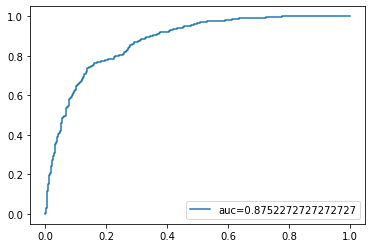

In [40]:
y_pred_proba = best_model.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

### xgboost

In [41]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from copy import copy

In [42]:
# XGBoost doesn't (yet) handle categorical features automatically, so need to change
# them to columns of integer values.

## encode string class values as integers
# le = LabelEncoder()
# le = le.fit(df_model["category"])
# df_model["category"] = le.transform(df_model["category"])

# split data into X and Y
# X = df.iloc[:,1:10]
# Y = df.iloc[:,10]

## encode string class values as integers
# le = LabelEncoder()
# label_encoder = le.fit(Y)
# label_encoded_y = le.transform(Y)

#seed = 1234
#test_size = 0.20

# train/test split
#X_train, X_test, y_train, y_test =  train_test_split(X, Y, test_size=test_size, random_state=seed)

In [43]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [44]:
# make predictions for test data
y_pred = model.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.17%


In [45]:
confusion_matrix(y_test, predictions)

array([[537,  68],
       [ 81, 319]])

In [46]:
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))
print("f1-score:",2*metrics.precision_score(y_test, predictions)*metrics.recall_score(y_test, predictions)
      /(metrics.precision_score(y_test, predictions)+metrics.recall_score(y_test, predictions)))

Precision: 0.8242894056847545
Recall: 0.7975
f1-score: 0.8106734434561627


#### This is our best model: with accuracy of 85.17% and f1-score of 0.81

### verifying feature significance

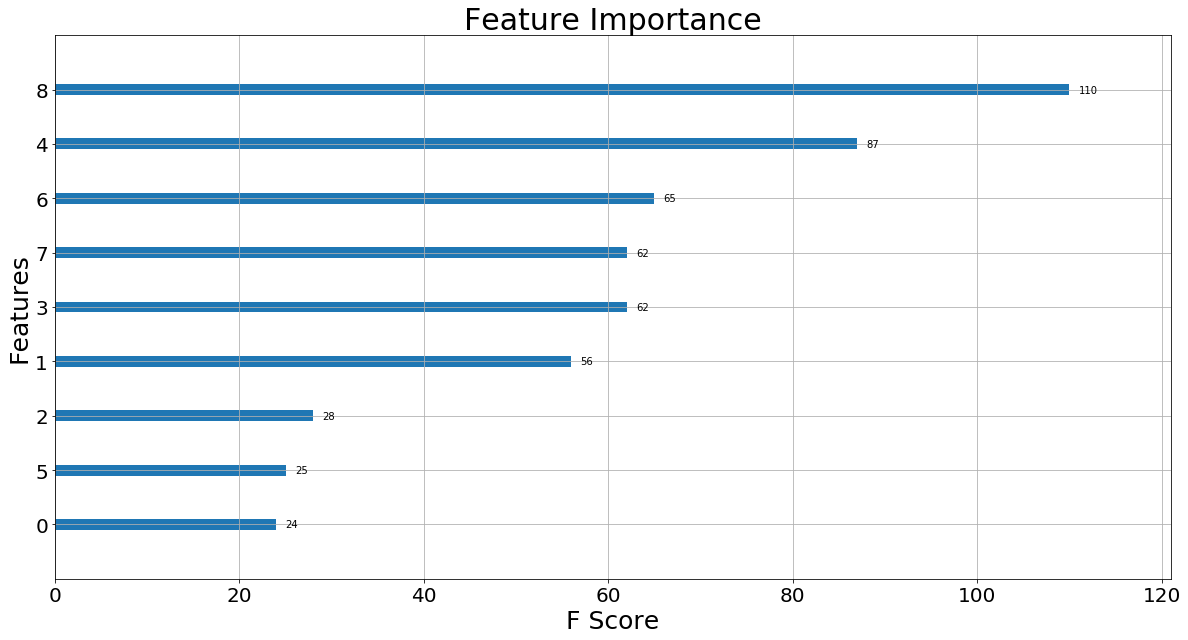

In [47]:
# feature importance use built-in XGBoost Feature Importance Plot
fig, ax = plt.subplots(1,1,figsize=(20,10))
xgb.plot_importance(model, ax=ax)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("F Score", fontsize=25)
plt.ylabel("Features", fontsize=25)
plt.title('Feature Importance', fontsize=30)
fig.savefig('featureInportance1.png')
plt.show()

### refit the logistic model: dropping the least important feature "levels"

In [48]:
df.drop(['levels'],axis=1)

,filename,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights,Go/NoGo
0,1007,1.0,0.028925,0.096045,0.096045,0.407767,0.407767,531,206,1
1,1008,1.0,0.027588,0.105461,0.105461,0.432990,0.432990,531,194,1
2,1011,2.0,0.028925,0.167608,0.167608,0.461165,0.665049,531,206,1
3,1016,4.0,0.033021,0.269492,0.089831,0.336927,0.412399,590,371,1
4,1026,2.0,0.034910,0.133710,0.097928,0.410494,0.410494,531,324,1
...,...,...,...,...,...,...,...,...,...,...
8366,995,8.0,0.041276,0.440678,0.239407,0.336927,0.781671,472,371,0
8367,996,3.0,0.037436,0.244821,0.081607,0.377215,0.377215,531,395,0
8368,997,4.0,0.029841,0.204931,0.102465,0.386667,0.656667,649,300,0
8369,998,9.0,0.037436,0.355932,0.222850,0.387342,1.050633,531,395,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc [:, 1:9] , df['Go/NoGo'], test_size=0.12, random_state=0)
## normalizing the feature vectors
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [50]:
## hyperparameter tuning
logreg = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
# balanced weights for class imbalance
penalty = ['l1', 'l2']
C =np.logspace(-2, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [51]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train_scaled, y_train)

In [52]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.046415888336127774


In [53]:
y_pred = best_model.predict(X_test_scaled)

In [54]:
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(100*best_model.score(X_test_scaled, y_test)))

Accuracy of logistic regression classifier on test set: 79.00%


In [55]:
## Confustion Matrix
confusion_matrix(y_test, y_pred)

array([[479, 126],
       [ 85, 315]])

In [56]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1-score:",2*metrics.precision_score(y_test, y_pred)*metrics.recall_score(y_test, y_pred)
      /(metrics.precision_score(y_test, y_pred)+metrics.recall_score(y_test, y_pred)))

Precision: 0.7142857142857143
Recall: 0.7875
f1-score: 0.7491082045184304


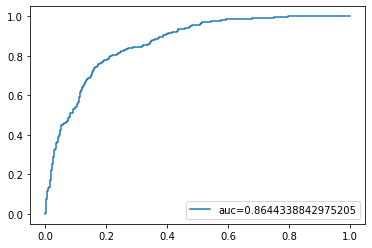

In [57]:
y_pred_proba = best_model.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### As the accuracy and other metrics decreased significantly, we decided not to exclude any feature